In [1]:
# 라이브러리 불러오기
import os
import cv2
import matplotlib.pyplot as plt
from pytesseract import image_to_string

import numpy as np
import time

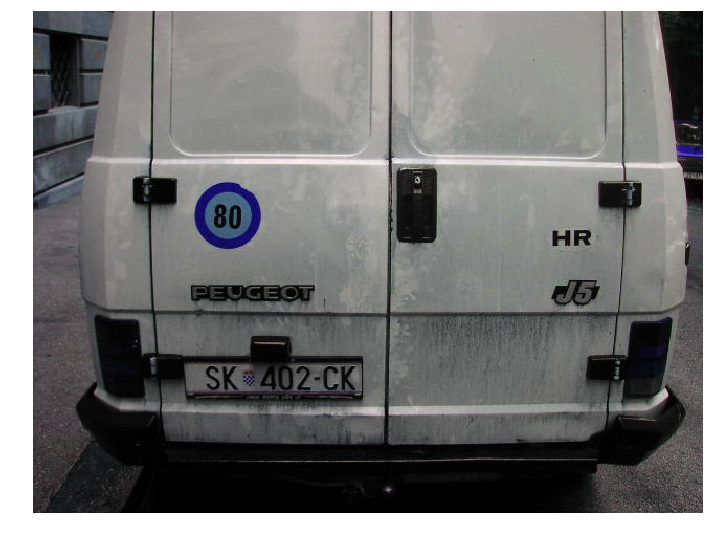

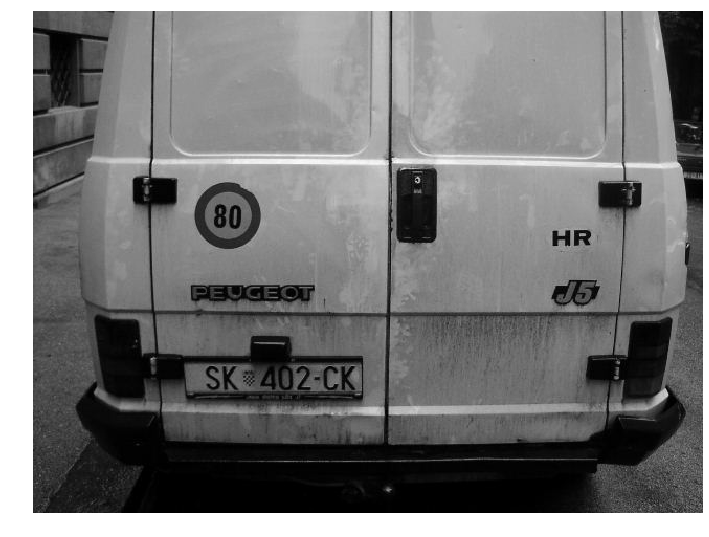

In [68]:
# 이미지 불러오기 

img_ex = cv2.imread('data/img/car_plate18.jpg') # 56번의 경우 최종 이미지 두 개가 뽑히기도 함!
height, width, channel = img_ex.shape

plt.figure(figsize = (12, 10))
plt.axis('off')
plt.imshow(img_ex, cmap='gray')

# 그레이스케일 적용
gray = cv2.cvtColor(img_ex, cv2.COLOR_BGR2GRAY)

plt.figure(figsize = (12, 10))
plt.axis('off')
plt.imshow(gray, cmap='gray')

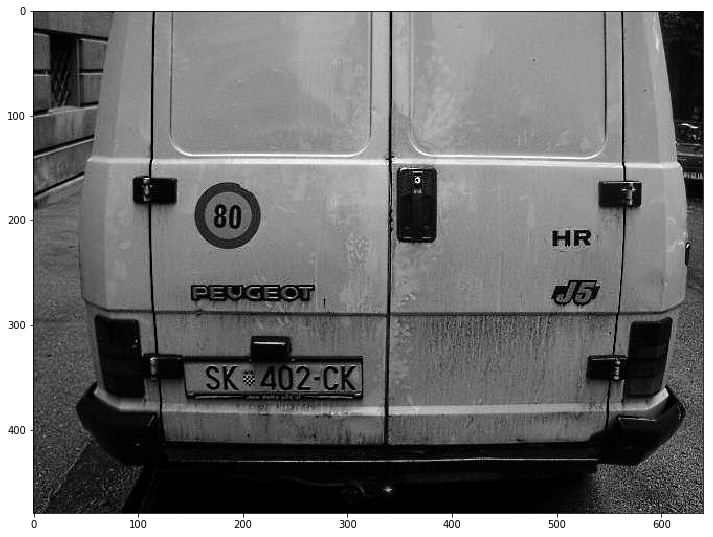

In [69]:
# 침식 연산 응용해(탑햇, 블랙햇) 추출 정확도 높이기
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

imgTH = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBH = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTH = cv2.add(gray, imgTH)
gray = cv2.subtract(imgGrayscalePlusTH, imgBH)

# plt.style.use('dark_background')
plt.figure(figsize = (12, 10))
plt.imshow(gray, cmap='gray') # 반복할 경우 이미지가 그대로 덧씌워지니 주의할 것

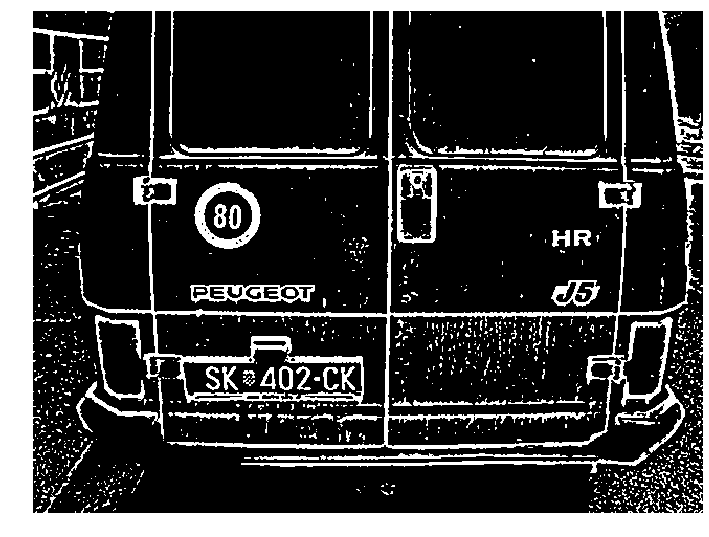

In [70]:
# Thresholding 하기
blurred = cv2.GaussianBlur(gray, (3,3), 0)

img_th = cv2.adaptiveThreshold(blurred,
                              maxValue=255.0,
                              adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                              thresholdType=cv2.THRESH_BINARY_INV,
                              blockSize=19,
                              C=9)
plt.figure(figsize = (12, 10))
plt.axis('off')
plt.imshow(img_th, cmap='gray')

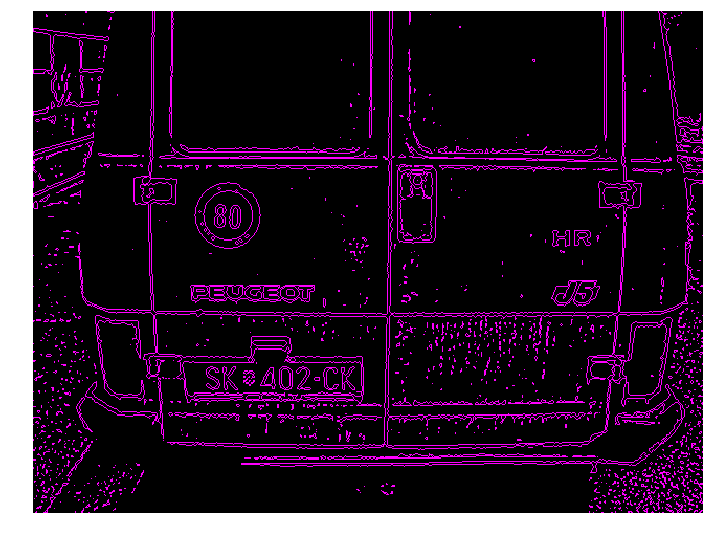

In [71]:
# contour 찾기
_, cnts, _=cv2.findContours(img_th, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(result, contours=cnts, contourIdx=-1, color=(255, 0, 255))

plt.figure(figsize = (12, 10))
plt.axis('off')
plt.imshow(result)

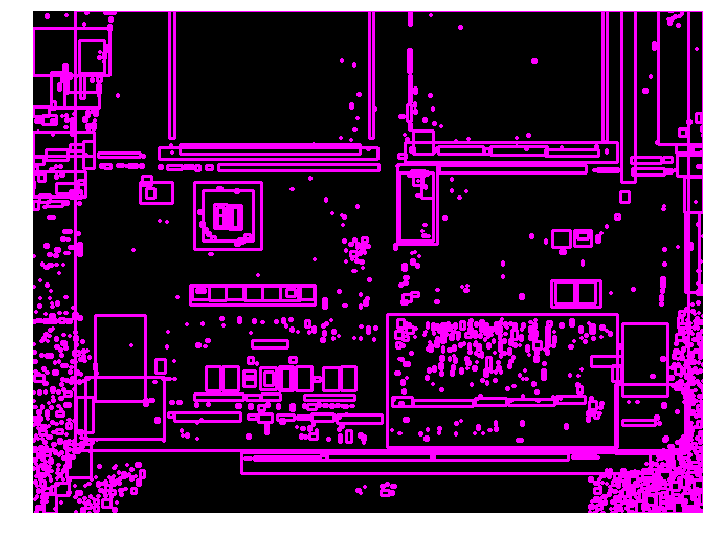

In [72]:
# 전체 이미지 contour 사각형 그리기
result = np.zeros((height, width, channel), dtype=np.uint8)

cnts_dict = []

for cnt in cnts:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 0, 255), thickness=2)
    
    cnts_dict.append({
        'contour':cnt,
        'x':x,
        'y':y,
        'w':w,
        'h':h,
        'cx':x + (w/2),
        'cy':y + (h/2)
    })
    
plt.figure(figsize = (12, 10))
plt.axis('off')
plt.imshow(result)

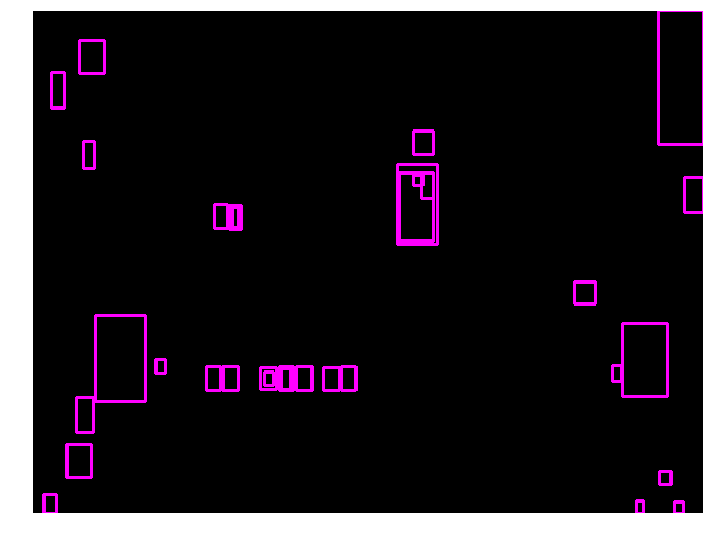

In [73]:
# contour 솎아내기
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATI0 = 0.25, 1.0

possible_cnts = []

cnt = 0
for d in cnts_dict:
    area = d['w']*d['h']
    ratio = d['w']/d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATI0:
        d['idx'] = cnt
        cnt += 1
        possible_cnts.append(d)
        
result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_cnts:
    cv2.rectangle(result, 
                  pt1=(d['x'], d['y']), 
                  pt2=(d['x']+d['w'], d['y']+d['h']),
                 color=(255, 0 , 255),
                 thickness=2)
    
plt.figure(figsize = (12, 10))
plt.axis('off')
plt.imshow(result, cmap='gray')

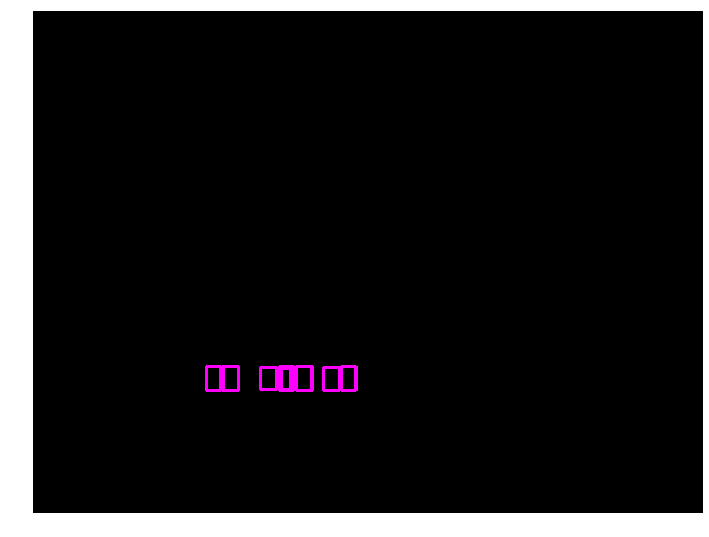

In [74]:
# 차량 번호판 contour 검출하기
MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3

def find_chars(cnt_list):
    matched_result_idx = []
    
    for d1 in cnt_list:
        matched_cnts_idx = []
        for d2 in cnt_list:
            if d1['idx'] == d2['idx']:
                continue
                
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            
            diagonal_length1 = np.sqrt(d1['w']**2 + d1['h']**2)
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy/dx))
            
            area_diff = abs(d1['w']*d1['h'] - d2['w']*d2['h']) / (d1['w']*d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_cnts_idx.append(d2['idx'])
                
        matched_cnts_idx.append(d1['idx'])
        
        if len(matched_cnts_idx) < MIN_N_MATCHED:
            continue
            
        matched_result_idx.append(matched_cnts_idx)
        
        unmatched_cnt_idx = []
        for d4 in cnt_list:
            if d4['idx'] not in matched_cnts_idx:
                unmatched_cnt_idx.append(d4['idx'])
                
        unmatched_cnt = np.take(possible_cnts, unmatched_cnt_idx)
        
        recursive_cnt_list = find_chars(unmatched_cnt)
        
        for idx in recursive_cnt_list:
            matched_result_idx.append(idx)
            
        break
        
    return matched_result_idx

result_idx = find_chars(possible_cnts)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_cnts, idx_list))
    
result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        cv2.rectangle(result, 
                      pt1=(d['x'], d['y']), 
                      pt2=(d['x']+d['w'], d['y']+d['h']), 
                      color=(255, 0, 255),
                     thickness=2)
        
plt.figure(figsize=(12,10))
plt.axis('off')
plt.imshow(result, cmap='gray')

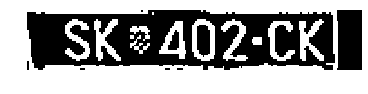

In [75]:
# 차량 번호판 부분만 crop 하기

PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x:x['cx'])
    
    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x'])*PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']
        
    plate_height = int(sum_height / len(sorted_chars)*PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
                                       np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']]))
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    rotation_mtrx = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    img_rotated = cv2.warpAffine(img_th, M=rotation_mtrx, dsize=(width, height))
    
    img_cropped = cv2.getRectSubPix(img_rotated,
                                   patchSize = (int(plate_width), int(plate_height)), 
                                   center=(int(plate_cx), int(plate_cy)))
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO \
    or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
        
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x':int(plate_cx - plate_width / 2),
        'y':int(plate_cy - plate_height / 2),
        'w':int(plate_width),
        'h':int(plate_height)})
    
    cv2.imwrite('cropped18.jpg', img_cropped)
    plt.subplot(len(matched_result), 1, i+1)
    plt.axis('off')
    plt.imshow(img_cropped, cmap='gray')

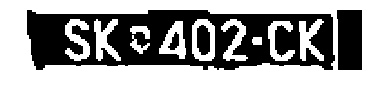

In [76]:
# 추출된 글자 전처리(Extra)
img_result = cv2.GaussianBlur(img_cropped, (5,5), 0)
_, img_result = cv2.threshold(img_result, 
                              thresh=0.0, 
                              maxval=255.0, 
                              type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
img_result = cv2.copyMakeBorder(img_result, 
                                top=0, 
                                bottom=0, 
                                left=0, 
                                right=0,
                               borderType=cv2.BORDER_CONSTANT, 
                                value=(0,0,0))

plt.imshow(img_result, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# # pytesseract로 글자 추출 결과 확인
# import PIL
# import pytesseract

# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

# text = pytesseract.image_to_string(img_result, lang='eng')

# result_texts = ''
# has_digit = False

# for n in text:
#     if ord('A') <= ord(n) <= ord('Z') or n.isdigit():
#         if n.isdigit():
#             has_digit = True
#             result_texts += n
    
# print(result_texts)